# Лабораторная работа 4. RL

**Выполнил**: Подцепко И.С., уч. группа M4138.

In [18]:
import ale_py  # to get access to ALE namespace
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from collections import deque
from IPython.display import display, clear_output
from torch import optim
from torchsummary import summary
from torchvision import transforms as T
from torchvision.transforms import functional as F
from gymnasium.wrappers import AtariPreprocessing

In [19]:
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

LR = 0.0005
BATCH_SIZE = 2048
GAMMA = 0.99

MEMORY_CAPACITY = 100000

MEMORY_START_SIZE = 10000
MEMORY_START_SIZE = max(MEMORY_START_SIZE, BATCH_SIZE)

Q_NETWORK_ITERATION = 100
SAVE_ITERATION = 100

In [20]:
def play(env):
    env.reset()
    done = False

    while not done:
        action = env.action_space.sample()
        observation, reward, done, _, info = env.step(action)
        img = plt.imshow(observation, cmap="Greys")
        display(plt.gcf())
        clear_output(wait=True)
        if not done:
            img.remove()

    env.close()

In [21]:
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

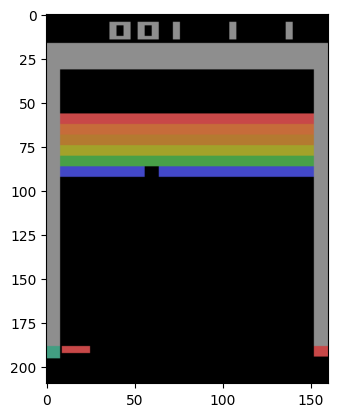

In [22]:
play(env)

In [23]:
class Crop:
    def __init__(self, top, left, height, width):
        self.top = top
        self.left = left
        self.height = height
        self.width = width

    def __call__(self, img):
        return F.crop(img, self.top, self.left, self.height, self.width)

In [24]:
def show_frames(env):
    image = env.render()
    N = image.shape[0]

    _, axes = plt.subplots(1, N, figsize=(20, 5))

    for i in range(N):
        axes[i].imshow(image[i], cmap="gray")
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/pdf/1312.5602)

In [55]:
class Breakout:
    def __init__(self, frame_stack_size: int = 4):
        self._env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

        # Environment interface
        self.action_space = self._env.action_space
        self.observation_space = self._env.observation_space

        # Preprocessing parameters
        self._transform = T.Compose(
            [
                T.ToPILImage(),
                T.Grayscale(),
                Crop(top=32, left=8, height=162, width=144),
                T.Resize(size=(84, 84)),
                T.ToTensor(),
            ]
        )

        self._initial_state, self._initial_meta = self._env.reset()
        self._frame_stack = deque(maxlen=frame_stack_size)
        self._reset_stack()

    def _reset_stack(self):
        self._frame_stack.extend([self._initial_state] * self._frame_stack.maxlen)

    def reset(self):
        self._env.reset()
        self._reset_stack()

        return self._render_impl(), self._initial_meta

    def step(self, action: int):
        frame, *meta = self._env.step(action)
        self._save(frame)
        return self._render_impl(), *meta

    def render(self, raw: bool = False):
        if raw:
            return self._frame_stack[-1]
        return self._render_impl()

    def _save(self, frame):
        self._frame_stack.append(frame)

    def _render_impl(self):
        return np.stack([self._preprocess_frame(frame) for frame in self._frame_stack])

    def _preprocess_frame(self, frame):
        return np.squeeze(self._transform(frame).numpy())

    def close(self):
        self._env.close()


env = Breakout()

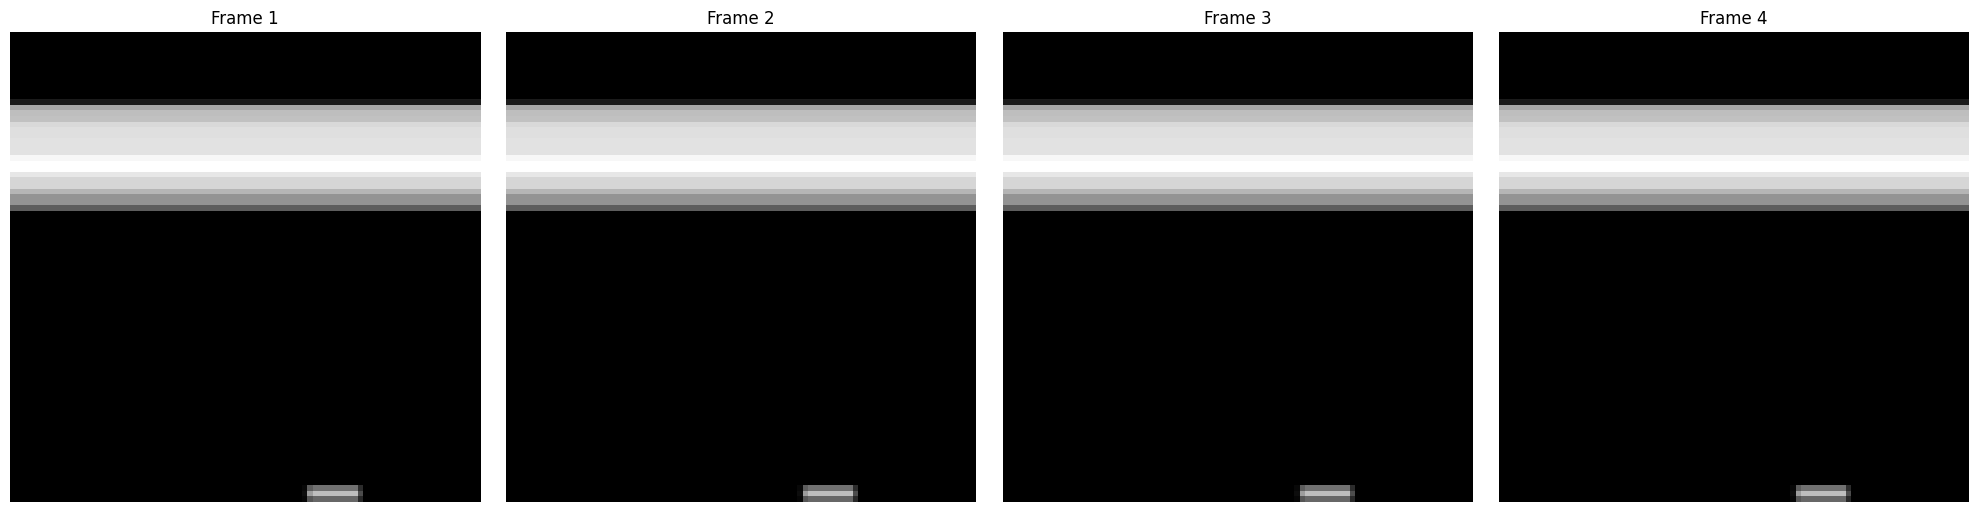

In [56]:
show_frames(env)

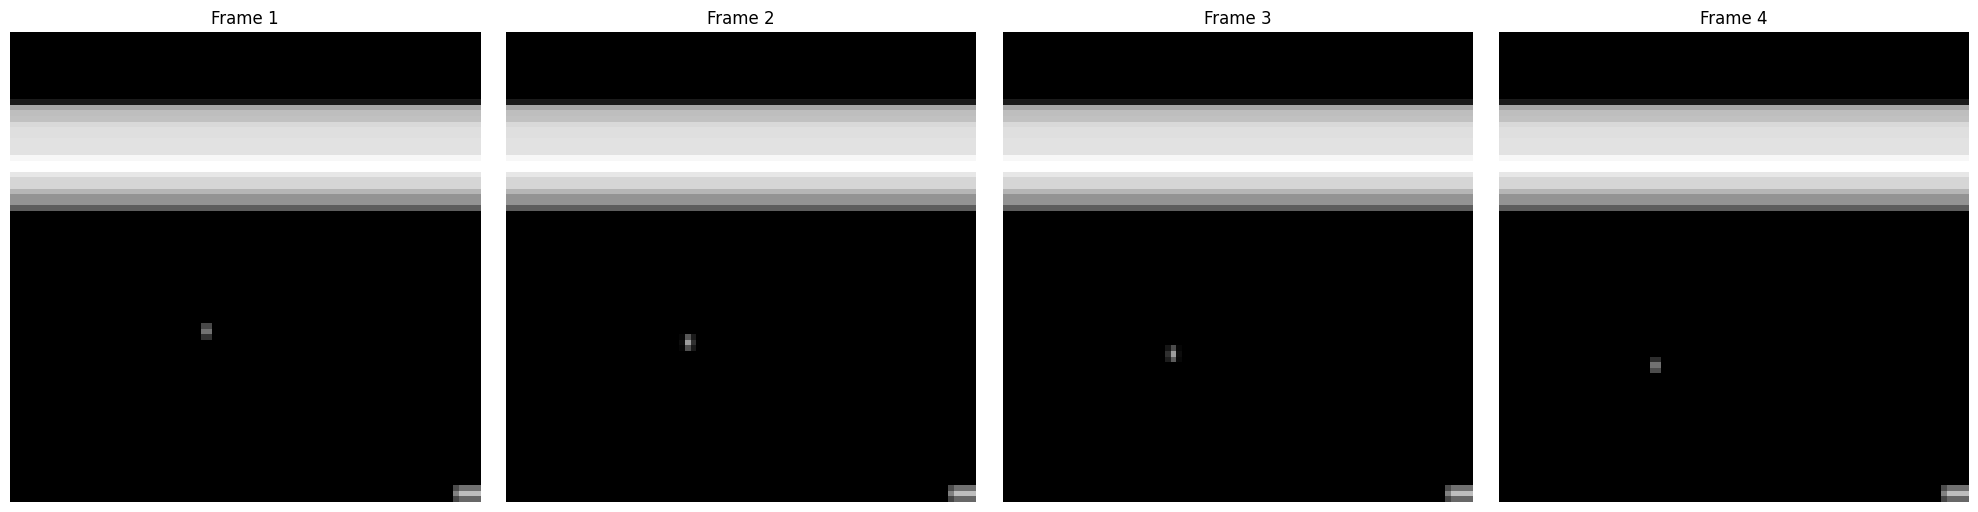

In [65]:
env.step(env.action_space.sample())
show_frames(env)

In [58]:
NUM_ACTIONS = env.action_space.n
assert NUM_ACTIONS == 4

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.PReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.PReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.PReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, NUM_ACTIONS),
        )

        self.conv.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        elif isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

In [30]:
summary(Net(), (4, 84, 84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
             PReLU-2           [-1, 32, 20, 20]               1
            Conv2d-3             [-1, 64, 9, 9]          32,832
             PReLU-4             [-1, 64, 9, 9]               1
            Conv2d-5             [-1, 64, 7, 7]          36,928
             PReLU-6             [-1, 64, 7, 7]               1
            Linear-7                  [-1, 512]       1,606,144
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 4]           2,052
Total params: 1,686,183
Trainable params: 1,686,183
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.33
Params size (MB): 6.43
Estimated Total Size (MB): 6.87
---------------------------------------

In [31]:
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_batch(self, batch_size):
        batch = np.random.choice(len(self.memory), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(
            *[self.memory[idx] for idx in batch]
        )

        states = torch.stack(
            [
                torch.tensor(state, dtype=torch.float32, device=DEVICE)
                for state in states
            ]
        )
        next_states = torch.stack(
            [
                torch.tensor(next_state, dtype=torch.float32, device=DEVICE)
                for next_state in next_states
            ]
        )
        actions = torch.tensor(actions, dtype=torch.long, device=DEVICE).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        dones = torch.tensor(dones, dtype=torch.bool, device=DEVICE).unsqueeze(1)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In [37]:
class DQN:
    def __init__(self):
        self.eval_net = Net().to(DEVICE)
        self.target_net = Net().to(DEVICE)
        self.target_net.load_state_dict(self.eval_net.state_dict())
        self.buffer = ExperienceReplay(MEMORY_CAPACITY)
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=LR)

    def get_action(self, state, epsilon):
        if epsilon > 0 and np.random.random() < epsilon:
            return env.action_space.sample()
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            return self.eval_net(state).argmax().item()

    def update(self, num_steps=10):
        for _ in range(num_steps):
            if len(self.buffer) < BATCH_SIZE:
                return
            states, actions, rewards, next_states, dones = self.buffer.get_batch(
                BATCH_SIZE
            )

            q_values = self.eval_net(states).gather(1, actions)
            with torch.no_grad():
                next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
                target_q_values = rewards + (GAMMA * next_q_values * ~dones)

            loss = torch.nn.functional.smooth_l1_loss(q_values, target_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [33]:
def train(dqn, episodes=1000, epsilon_start=1.0, epsilon_end=0.1):
    epsilon = epsilon_start
    all_rewards = []
    rewards_window = []

    epsilon_delta = (epsilon_start - epsilon_end) / (episodes - 1)
    for episode in range(episodes):
        epsilon = epsilon_start - epsilon_delta * episode

        state, _ = env.reset()
        ep_reward = 0
        while True:
            action = dqn.get_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            dqn.buffer.store_transition(state, action, reward, next_state, done)
            ep_reward += int(reward)
            state = next_state

            if done:
                break

        if len(dqn.buffer) >= MEMORY_START_SIZE:
            dqn.update()

        if episode % Q_NETWORK_ITERATION == 0:
            dqn.target_net.load_state_dict(dqn.eval_net.state_dict())
        if (episode + 1) % SAVE_ITERATION == 0:
            torch.save(dqn.target_net.state_dict(), f"target_net_{episode + 1}.pt")

        all_rewards.append(ep_reward)
        rewards_window.append(ep_reward)

        if len(rewards_window) == 100:
            print(
                f"Episode {episode + 1:7}, Reward: {ep_reward:2}, Average: {np.mean(rewards_window):.2f}, Epsilon: {epsilon:.2f}"
            )
            rewards_window = []

    return all_rewards

Episode     100, Reward:  0, Average: 1.90, Epsilon: 0.15
Episode     200, Reward:  7, Average: 2.27, Epsilon: 0.15
Episode     300, Reward:  2, Average: 1.93, Epsilon: 0.14
Episode     400, Reward:  2, Average: 1.65, Epsilon: 0.14
Episode     500, Reward:  3, Average: 2.06, Epsilon: 0.14
Episode     600, Reward:  5, Average: 2.48, Epsilon: 0.14
Episode     700, Reward:  9, Average: 2.08, Epsilon: 0.14
Episode     800, Reward:  4, Average: 1.90, Epsilon: 0.13
Episode     900, Reward:  3, Average: 2.02, Epsilon: 0.13
Episode    1000, Reward:  0, Average: 1.38, Epsilon: 0.13
Episode    1100, Reward:  1, Average: 1.20, Epsilon: 0.13
Episode    1200, Reward:  0, Average: 1.09, Epsilon: 0.13
Episode    1300, Reward:  4, Average: 0.85, Epsilon: 0.12
Episode    1400, Reward:  2, Average: 2.12, Epsilon: 0.12
Episode    1500, Reward:  2, Average: 2.30, Epsilon: 0.12
Episode    1600, Reward:  3, Average: 2.56, Epsilon: 0.12
Episode    1700, Reward:  8, Average: 2.98, Epsilon: 0.12
Episode    180

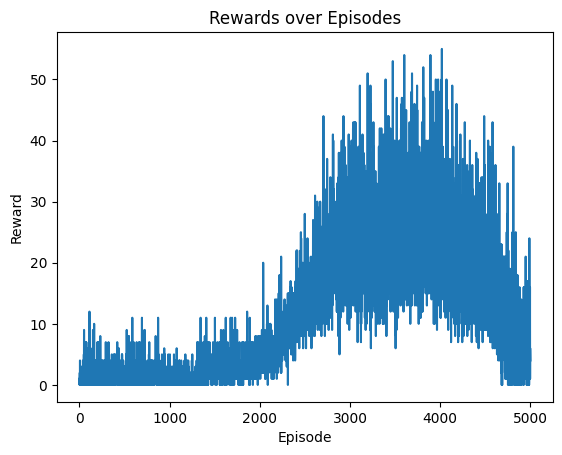

In [34]:
torch.mps.empty_cache()

dqn = DQN()
rewards = train(dqn, episodes=5_000, epsilon_start=0.15, epsilon_end=0.05)

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards over Episodes")
plt.show()

In [35]:
torch.save(dqn.target_net.state_dict(), "target_last.pt")

In [44]:
dqn.eval_net.load_state_dict(torch.load("target_net_3600.pt", weights_only=True))

<All keys matched successfully>

In [49]:
def play_with_ai(env, model, epsilon):
    state, _ = env.reset()
    done = False

    while not done:
        action = model.get_action(state, epsilon)
        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state

        img = plt.imshow(env.render(raw=True), cmap="Greys")
        display(plt.gcf())
        clear_output(wait=True)
        if not done:
            img.remove()

    env.close()

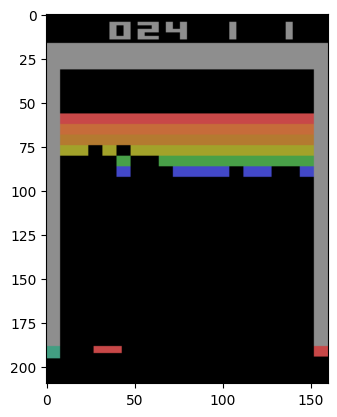

In [66]:
play_with_ai(env, dqn, epsilon=0.01)

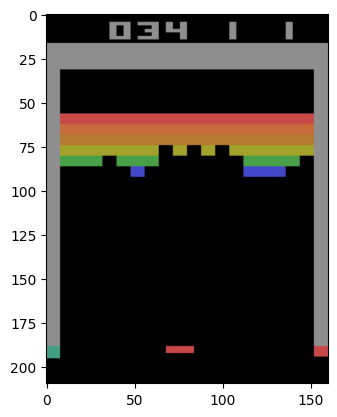

In [53]:
play_with_ai(env, dqn, epsilon=0.0)

**Выводы**:
1. Модели удается добиваться результатов от 20 до 40 за игру.
2. При нескольких запусках было замечено, что модель не часто угадывает действие `FIRE`.
3. Идеи по улучшению:
   1. Уменьшить скорость снижения `epsilon`;
   2. Увеличить параметры `MEMORY_CAPACITY`, `BATCH_SIZE` и `num_steps`, чтобы при обучении использовалось разнообразие сосстояний игры — это поможет остаться в локальном минимуме;
   3. Изменять `lr`, используя `lr_scheduler`.